In [1]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('fivethirtyeight')
from matplotlib.ticker import FuncFormatter
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
import spacy
from sklearn.feature_extraction.text import CountVectorizer
import os

In [2]:
train = pd.read_csv('../input/feedback-prize-2021/train.csv')
train[['discourse_id', 'discourse_start', 'discourse_end']] = train[['discourse_id', 'discourse_start', 'discourse_end']].astype(int)

sample_submission = pd.read_csv('../input/feedback-prize-2021/sample_submission.csv')

#The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell
train_txt = glob('../input/feedback-prize-2021/train/*.txt') 
test_txt = glob('../input/feedback-prize-2021/test/*.txt')

In [3]:
!cat ../input/feedback-prize-2021/train/423A1CA112E2.txt

Phones

Modern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving. They are some really bad consequences when stuff happens when it comes to a phone. Some certain areas in the United States ban phones from class rooms just because of it.

When people have phones, they know about certain apps that they have .Apps like Facebook Twitter Instagram and Snapchat. So like if a friend moves away and you want to be in contact you can still be in contact by posting videos or text messages. People always have different ways how to communicate with a phone. Phones have changed due to our generation.

Driving is one of the way how to get around. People always be on their phones while doing it. Which can cause serious Problems. That's why there's a thing that's called no texting while driving. That's a really important thing to remember. S

The train dataset gives us the following human annotations that are extracted from this essay.

In [4]:
train.query('id == "423A1CA112E2"')

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1622627660524,8,229,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1622627653021,230,312,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1622627671020,313,401,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1622627696365,402,758,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1622627759780,759,886,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...
5,423A1CA112E2,1622627780655,887,1150,That's why there's a thing that's called no te...,Evidence,Evidence 3,163 164 165 166 167 168 169 170 171 172 173 17...
6,423A1CA112E2,1622627811787,1151,1533,Sometimes on the news there is either an accid...,Evidence,Evidence 4,211 212 213 214 215 216 217 218 219 220 221 22...
7,423A1CA112E2,1622627585180,1534,1602,Phones are fine to use and it's also the best ...,Claim,Claim 2,282 283 284 285 286 287 288 289 290 291 292 29...
8,423A1CA112E2,1622627895668,1603,1890,If you go through a problem and you can't find...,Evidence,Evidence 5,297 298 299 300 301 302 303 304 305 306 307 30...
9,423A1CA112E2,1622627628524,1891,2027,The news always updated when people do somethi...,Concluding Statement,Concluding Statement 1,355 356 357 358 359 360 361 362 363 364 365 36...


Kaggle gives us the following field descriptions:
- id - ID code for essay response
- discourse_id - ID code for discourse element
- discourse_start - character position where discourse element begins in the essay response
- discourse_end - character position where discourse element ends in the essay response
- discourse_text - text of discourse element
- discourse_type - classification of discourse element
- discourse_type_num - enumerated class label of discourse element
- predictionstring - the word indices of the training sample, as required for predictions

The Ground Truth here is a combination of the discourse type and the prediction string. The predictionstring corresponds to the index of the words in the essay and the predicted discourse type for this sequence of words should be correct. There can be partial matches, if the correct discourse type is predicted but on a longer or shorter sequence of words than specified in the Ground Truth.

As we can see, not necessarily all text of an essay is part of a discourse. In this case, the title is not part of any discourse.


# Lenght of the discourse_text and predictionstring
First, I would like to check if the discourse_text and the predictionstring always have the same number of words (as they should).

In [5]:
#add columns
train["discourse_len"] = train["discourse_text"].apply(lambda x: len(x.split()))
train["pred_len"] = train["predictionstring"].apply(lambda x: len(x.split()))


cols_to_display = ['discourse_id', 'discourse_text', 'discourse_type','predictionstring', 'discourse_len', 'pred_len']
train[cols_to_display].head()

,discourse_id,discourse_text,discourse_type,predictionstring,discourse_len,pred_len
0,1622627660524,Modern humans today are always on their phone....,Lead,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,44,44
1,1622627653021,They are some really bad consequences when stu...,Position,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59,15,15
2,1622627671020,Some certain areas in the United States ban ph...,Evidence,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75,16,16
3,1622627696365,"When people have phones, they know about certa...",Evidence,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...,63,63
4,1622627759780,Driving is one of the way how to get around. P...,Claim,139 140 141 142 143 144 145 146 147 148 149 15...,24,24


Is this always correct? No, I find 468 discourses where this goes wrong (by one word)

In [6]:
print(f"The total number of discourses is {len(train)}")
train.query('discourse_len != pred_len')[cols_to_display]

The total number of discourses is 144293


,discourse_id,discourse_text,discourse_type,predictionstring,discourse_len,pred_len
107,1622473475289,if we would just make stricker laws for phone ...,Concluding Statement,303 304 305 306 307 308 309 310 311 312 313 31...,19,18
1025,1622564912260,for navigation to wherever they are going,Claim,105 106 107 108 109 110 111 112,7,8
1525,1622992466917,People should not be able to use cell phones w...,Position,22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 3...,47,48
1526,1622992280991,"First, cell phones are a benefit and allows ev...",Claim,69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 8...,21,22
1527,1622992426147,"Kids, teenagers, adults, even grandparents hav...",Evidence,90 91 92 93 94 95 96 97 98 99 100 101 102 103 ...,78,79
...,...,...,...,...,...,...
142607,1617826841342,seeking people's opinions on making a choice i...,Concluding Statement,563 564 565 566 567 568 569 570 571 572 573 57...,51,50
143191,1617887956153,i feel like for the bst advice ask more then o...,Evidence,185 186 187 188 189 190 191 192 193 194 195 19...,83,82
143227,1617652582742,", asking for advice from multiple people will ...",Concluding Statement,467 468 469 470 471 472 473 474 475 476 477 47...,84,83
143311,1618286838241,Seeking multiple opinions can help make a bett...,Claim,159 160 161 162 163 164 165 166 167 168 169 17...,15,16


Let's check the first one.

In [7]:
print(train.query('discourse_id == 1622473475289')['discourse_text'].values[0])
print(train.query('discourse_id == 1622473475289')['discourse_text'].values[0].split())
print(len(train.query('discourse_id == 1622473475289')['discourse_text'].values[0].split()))

if we would just make stricker laws for phone an driving the people would stop because of the consequences.      
['if', 'we', 'would', 'just', 'make', 'stricker', 'laws', 'for', 'phone', 'an', 'driving', 'the', 'people', 'would', 'stop', 'because', 'of', 'the', 'consequences.']
19


The length of 19 words seems correct to me, and the length of the predictionstring also really seems to be 18. Something to keep in mind.

**Update:** the answers to this can be found in discussion topic: [Mystery Solved - Discrepancy Between PredictionString and DiscourseText](https://www.kaggle.com/c/feedback-prize-2021/discussion/297591)

In [8]:
print(train.query('discourse_id == 1622473475289')['predictionstring'].values[0])
print(train.query('discourse_id == 1622473475289')['predictionstring'].values[0].split())
print(len(train.query('discourse_id == 1622473475289')['predictionstring'].values[0].split()))

303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320
['303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319', '320']
18


# Length and frequency and relative position per discourse_type

Is there a correlation between the length of a discourse and the class (discourse_type)? Yes, there is. Evidence is the longest discount type on average. When looking at the frequencies of occurence, we see that Counterclaim and Rebuttal are relatively rare

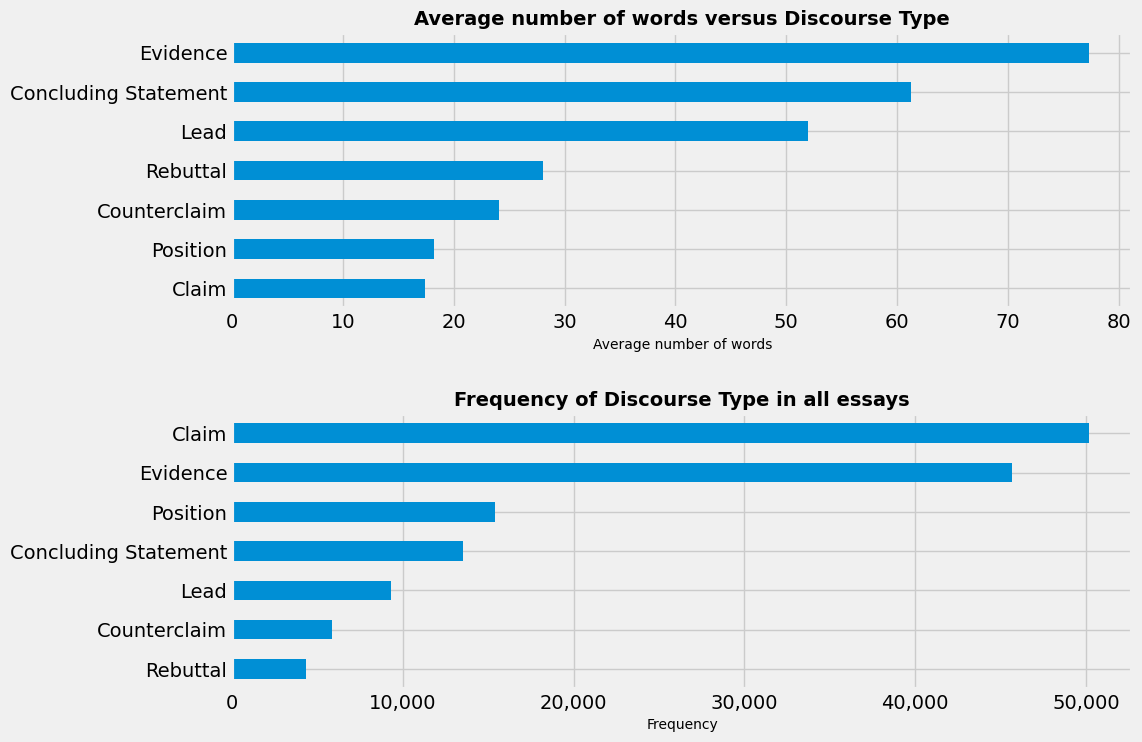

In [9]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
ax1 = train.groupby('discourse_type')['discourse_len'].mean().sort_values().plot(kind="barh")
ax1.set_title("Average number of words versus Discourse Type", fontsize=14, fontweight = 'bold')
ax1.set_xlabel("Average number of words", fontsize = 10)
ax1.set_ylabel("")

ax2 = fig.add_subplot(212)
ax2 = train.groupby('discourse_type')['discourse_type'].count().sort_values().plot(kind="barh")
ax2.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) #add thousands separator
ax2.set_title("Frequency of Discourse Type in all essays", fontsize=14, fontweight = 'bold')
ax2.set_xlabel("Frequency", fontsize = 10)
ax2.set_ylabel("")

plt.tight_layout(pad=2)
plt.show()

We do have the field discourse_type_num. We see that Evidence1, Position1 and Claim1 are almost always there in an essay. Most students also had at least one Concluding Statement. What's surprising to me is that a Lead is missing in about 40% of the essays (Lead 1 is found in almost 60% of the essays).

The graph only plots discourse_type_nums which are found in at least 3% of the essays.

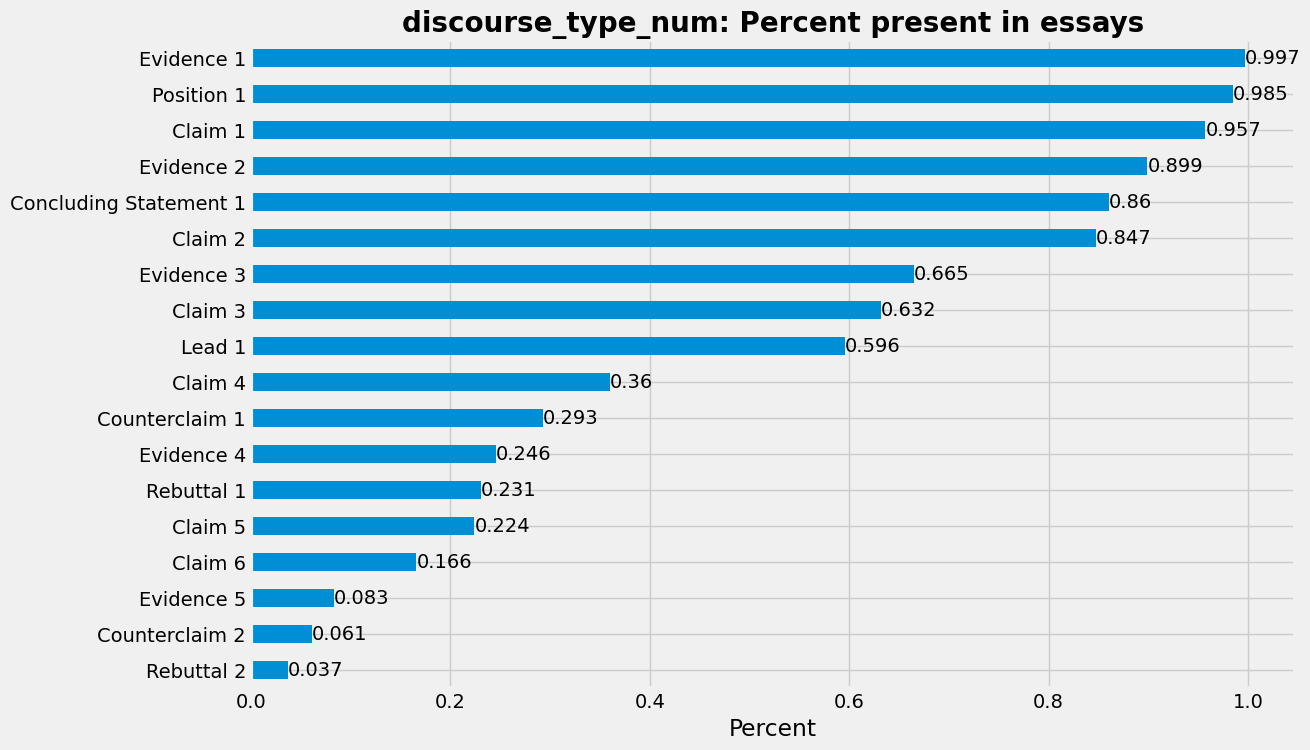

In [10]:
fig = plt.figure(figsize=(12,8))
av_per_essay = train['discourse_type_num'].value_counts(ascending = True).rename_axis('discourse_type_num').reset_index(name='count')
av_per_essay['perc'] = round((av_per_essay['count'] / train.id.nunique()),3)
av_per_essay = av_per_essay.set_index('discourse_type_num')
ax = av_per_essay.query('perc > 0.03')['perc'].plot(kind="barh")
ax.set_title("discourse_type_num: Percent present in essays", fontsize=20, fontweight = 'bold')
ax.bar_label(ax.containers[0], label_type="edge")
ax.set_xlabel("Percent")
ax.set_ylabel("")
plt.show()

Below you can see a plot with the average positions of the discourse start and end.

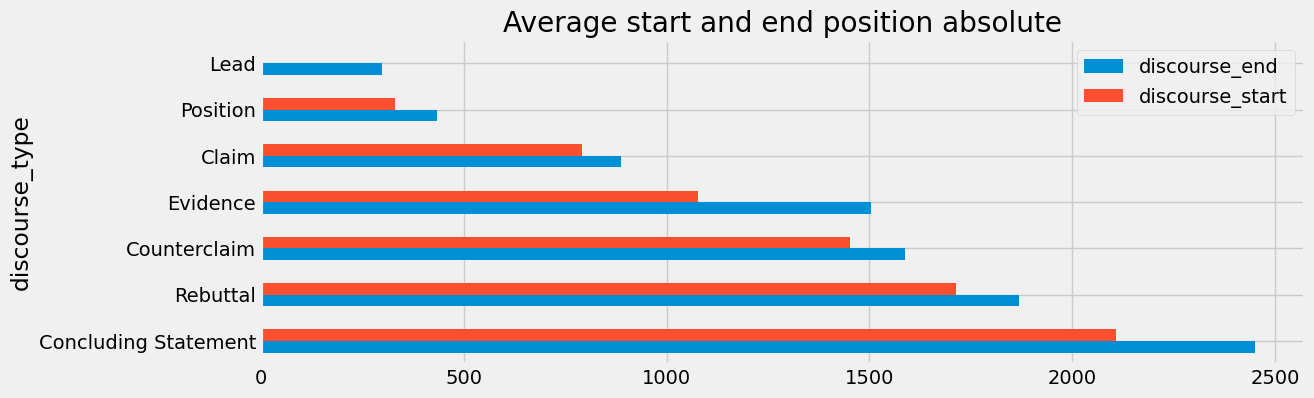

In [11]:
data = train.groupby("discourse_type")[['discourse_end', 'discourse_start']].mean().reset_index().sort_values(by = 'discourse_start', ascending = False)
data.plot(x='discourse_type',
        kind='barh',
        stacked=False,
        title='Average start and end position absolute',
        figsize=(12,4))
plt.show()

I am also interested in the relative positions of discourse types with the essays. Below you can see the distributions of the discourse types of the first and last discourses identified.

In [12]:
train_first = train.drop_duplicates(subset = "id", keep = "first").discourse_type.value_counts().rename_axis('discourse_type').reset_index(name='counts_first')
train_first['percent_first'] = round((train_first['counts_first']/train.id.nunique()),2)
train_last = train.drop_duplicates(subset = "id", keep = "last").discourse_type.value_counts().rename_axis('discourse_type').reset_index(name='counts_last')
train_last['percent_last'] = round((train_last['counts_last']/train.id.nunique()),2)
train_first_last = train_first.merge(train_last, on = "discourse_type", how = "left")
train_first_last

,discourse_type,counts_first,percent_first,counts_last,percent_last
0,Lead,9298,0.60,3,0.00
1,Position,5760,0.37,521,0.03
2,Evidence,261,0.02,1609,0.10
3,Claim,255,0.02,285,0.02
4,Counterclaim,19,0.00,30,0.00
5,Concluding Statement,1,0.00,12993,0.83


We also know that a Lead is missing in around 40% of the essays. Below you can see that if there is a Lead, it's almost always the first discourse identified in an essay (Lead 2 is very rare anyway).

In [13]:
train['discourse_nr'] = 1
counter = 1

for i in tqdm(range(1, len(train))):
    if train.loc[i, 'id'] == train.loc[i-1, 'id']:
        counter += 1
        train.loc[i, 'discourse_nr'] = counter
    else:
        counter = 1
        train.loc[i, 'discourse_nr'] = counter

#if you are interested in other discourse_types you can add them to the list in df.query
train.query('discourse_type in ["Lead"]').groupby('discourse_type_num')['discourse_nr'].value_counts().to_frame('occurences')

  0%|          | 0/144292 [00:00<?, ?it/s]

occurences
discourse_type_num discourse_nr            
Lead 1             1                   9298
                   2                      3
Lead 2             2                      1
                   10                     1
                   15                     1
                   16                     1

# Investigation the gaps between Annotations (text not used as discourse_text)

Just taking the last discourse_end in train is not entirely correct as a last piece of text may not have been used as a discourse. Therefore, I will go through the essays to find the real ends. Eh....until I remembered that Rob Mulla already did that in the excellent EDA [Student Writing Competition [Twitch Stream]](https://www.kaggle.com/robikscube/student-writing-competition-twitch) ;-). Please upvote his notebook!

In [14]:
# this code chunk is copied from Rob Mulla
len_dict = {}
word_dict = {}
for t in tqdm(train_txt):
    with open(t, "r") as txt_file:
        myid = t.split("/")[-1].replace(".txt", "")
        data = txt_file.read()
        mylen = len(data.strip())
        myword = len(data.split())
        len_dict[myid] = mylen
        word_dict[myid] = myword
train["essay_len"] = train["id"].map(len_dict)
train["essay_words"] = train["id"].map(word_dict)

  0%|          | 0/15594 [00:00<?, ?it/s]

When comparing the discourse_end of the last discourse in each essay, we see that the discourse_end is sometimes larger than the essay_len. This cannot be right, but I will assume that those are last pieces of text in the essay indeed.

In [15]:
#initialize column
train['gap_length'] = np.nan

#set the first one
train.loc[0, 'gap_length'] = 7 #discourse start - 1 (previous end is always -1)

#loop over rest
for i in tqdm(range(1, len(train))):
    #gap if difference is not 1 within an essay
    if ((train.loc[i, "id"] == train.loc[i-1, "id"])\
        and (train.loc[i, "discourse_start"] - train.loc[i-1, "discourse_end"] > 1)):
        train.loc[i, 'gap_length'] = train.loc[i, "discourse_start"] - train.loc[i-1, "discourse_end"] - 2
        #minus 2 as the previous end is always -1 and the previous start always +1
    #gap if the first discourse of an new essay does not start at 0
    elif ((train.loc[i, "id"] != train.loc[i-1, "id"])\
        and (train.loc[i, "discourse_start"] != 0)):
        train.loc[i, 'gap_length'] = train.loc[i, "discourse_start"] -1


 #is there any text after the last discourse of an essay?
last_ones = train.drop_duplicates(subset="id", keep='last')
last_ones['gap_end_length'] = np.where((last_ones.discourse_end < last_ones.essay_len),\
                                       (last_ones.essay_len - last_ones.discourse_end),\
                                       np.nan)

cols_to_merge = ['id', 'discourse_id', 'gap_end_length']
train = train.merge(last_ones[cols_to_merge], on = ["id", "discourse_id"], how = "left")

  0%|          | 0/144292 [00:00<?, ?it/s]

In [16]:
#display an example
cols_to_display = ['id', 'discourse_start', 'discourse_end', 'discourse_type', 'essay_len', 'gap_length', 'gap_end_length']
train[cols_to_display].query('id == "AFEC37C2D43F"')

,id,discourse_start,discourse_end,discourse_type,essay_len,gap_length,gap_end_length
144270,AFEC37C2D43F,0,317,Lead,3140,NaN,NaN
144271,AFEC37C2D43F,318,515,Position,3140,NaN,NaN
144272,AFEC37C2D43F,684,692,Claim,3140,167.0,NaN
144273,AFEC37C2D43F,693,710,Claim,3140,NaN,NaN
144274,AFEC37C2D43F,714,724,Claim,3140,2.0,NaN
144275,AFEC37C2D43F,725,1360,Evidence,3140,NaN,NaN
144276,AFEC37C2D43F,1361,1471,Claim,3140,NaN,NaN
144277,AFEC37C2D43F,1472,1881,Evidence,3140,NaN,NaN
144278,AFEC37C2D43F,1882,2019,Claim,3140,NaN,NaN
144279,AFEC37C2D43F,2029,2123,Claim,3140,8.0,NaN


In [17]:
#how many pieces of tekst are not used as discourses?
print(f"Besides the {len(train)} discourse texts, there are {len(train.query('gap_length.notna()', engine='python'))+ len(train.query('gap_end_length.notna()', engine='python'))} pieces of text not classified.")

Besides the 144293 discourse texts, there are 32162 pieces of text not classified.


Although the gaps in the example above are small, we do have huge gaps in a number of essays.

In [18]:
train.sort_values(by = "gap_length", ascending = False)[cols_to_display].head()

,id,discourse_start,discourse_end,discourse_type,essay_len,gap_length,gap_end_length
12921,7330313ED3F0,3377,3846,Concluding Statement,3829,2245.0,NaN
20537,7DF12B42AB72,3596,4231,Rebuttal,6012,2232.0,NaN
11685,4DF55925F544,2845,3013,Evidence,3846,2137.0,NaN
88336,43CBE96B374E,3115,3371,Concluding Statement,3689,1726.0,318.0
103994,134A4DA02013,2049,2176,Claim,3301,1680.0,NaN


In [19]:
train.sort_values(by = "gap_end_length", ascending = False)[cols_to_display].head()

,id,discourse_start,discourse_end,discourse_type,essay_len,gap_length,gap_end_length
28134,C278EDC82048,524,667,Evidence,8015,NaN,7348.0
8567,129497C3E0FC,386,443,Position,3616,103.0,3173.0
1204,F92664C55FBB,541,628,Evidence,3767,NaN,3139.0
91438,F5EE08CB44B9,124,353,Claim,3022,NaN,2669.0
6110,8E3B8CFD4256,1111,1295,Claim,3821,NaN,2526.0


Below, you can see a histogram of the length of all gaps with the outliers taken out (all gaps longer than 300 characters).

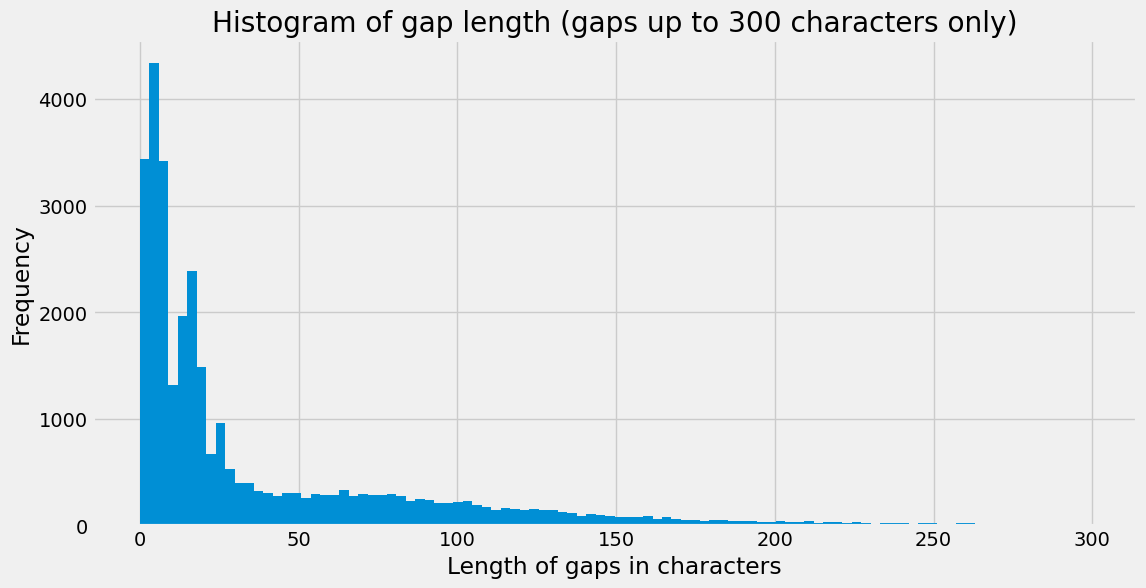

In [20]:
# Assuming train is your DataFrame and it has columns 'gap_length' and 'gap_end_length'
all_gaps = pd.concat([train.gap_length.dropna(), train.gap_end_length.dropna()], ignore_index=True)

# Filter outliers
all_gaps = all_gaps[all_gaps < 300]

# Plot histogram
fig = plt.figure(figsize=(12, 6))
all_gaps.plot.hist(bins=100)
plt.title("Histogram of gap length (gaps up to 300 characters only)")
plt.xticks(rotation=0)
plt.xlabel("Length of gaps in characters")
plt.show()

# Are there many really bad essays (large percentage of text not classified)?
Yes, we do have those. Some have around 90% of text not classified as one of the discourse types.

Regarding the one with gap_end_length 7348: I found out that this student just copied and pasted the same texts multiple times in his/her essay. See discussion topic: [Finding: essay with all text repeated many times](https://www.kaggle.com/c/feedback-prize-2021/discussion/298193).

In [21]:
total_gaps = train.groupby('id').agg({'essay_len': 'first',\
                                               'gap_length': 'sum',\
                                               'gap_end_length': 'sum'})
total_gaps['perc_not_classified'] = round(((total_gaps.gap_length + total_gaps.gap_end_length)/total_gaps.essay_len),2)

total_gaps.sort_values(by = 'perc_not_classified', ascending = False).head()

,essay_len,gap_length,gap_end_length,perc_not_classified
id,,,,
C278EDC82048,8015,13.0,7348.0,0.92
129497C3E0FC,3616,130.0,3173.0,0.91
F5EE08CB44B9,3022,62.0,2669.0,0.90
B7C17E1993BA,3569,1110.0,2060.0,0.89
F45B396E0A01,1865,1657.0,0.0,0.89


# Color printing essays including the gaps

I saw  a very pretty way to do this in the Notebook made by Sanskar Hasija (https://www.kaggle.com/odins0n/feedback-prize-eda). The code is nice but did not print the gaps yet. Below, I make a function that adds all gaps in an essay as rows with discourse type "Nothing".

In [22]:
def add_gap_rows(essay):
    cols_to_keep = ['discourse_start', 'discourse_end', 'discourse_type', 'gap_length', 'gap_end_length']
    df_essay = train.query('id == @essay')[cols_to_keep].reset_index(drop = True)

    #index new row
    insert_row = len(df_essay)
   
    for i in range(1, len(df_essay)):          
        if df_essay.loc[i,"gap_length"] >0:
            if i == 0:
                start = 0 #as there is no i-1 for first row
                end = df_essay.loc[0, 'discourse_start'] -1
                disc_type = "Nothing"
                gap_end = np.nan
                gap = np.nan
                df_essay.loc[insert_row] = [start, end, disc_type, gap, gap_end]
                insert_row += 1
            else:
                start = df_essay.loc[i-1, "discourse_end"] + 1
                end = df_essay.loc[i, 'discourse_start'] -1
                disc_type = "Nothing"
                gap_end = np.nan
                gap = np.nan
                df_essay.loc[insert_row] = [start, end, disc_type, gap, gap_end]
                insert_row += 1

    df_essay = df_essay.sort_values(by = "discourse_start").reset_index(drop=True)

    #add gap at end
    if df_essay.loc[(len(df_essay)-1),'gap_end_length'] > 0:
        start = df_essay.loc[(len(df_essay)-1), "discourse_end"] + 1
        end = start + df_essay.loc[(len(df_essay)-1), 'gap_end_length']
        disc_type = "Nothing"
        gap_end = np.nan
        gap = np.nan
        df_essay.loc[insert_row] = [start, end, disc_type, gap, gap_end]
        
    return(df_essay)

In [23]:
add_gap_rows("129497C3E0FC")

,discourse_start,discourse_end,discourse_type,gap_length,gap_end_length
0,0,57.0,Lead,NaN,NaN
1,58,111.0,Claim,NaN,NaN
2,112,120.0,Nothing,NaN,NaN
3,121,137.0,Claim,8.0,NaN
4,138,157.0,Nothing,NaN,NaN
5,158,281.0,Counterclaim,19.0,NaN
6,282,385.0,Nothing,NaN,NaN
7,386,443.0,Position,103.0,3173.0
8,444,3617.0,Nothing,NaN,NaN


This enables me to make a function that uses the code made by Sanskar Hasija to color print an essay including the gaps.

In [24]:
def print_colored_essay(essay):
    df_essay = add_gap_rows(essay)
    #code from https://www.kaggle.com/odins0n/feedback-prize-eda, but adjusted to df_essay
    essay_file = "../input/feedback-prize-2021/train/" + essay + ".txt"

    ents = []
    for i, row in df_essay.iterrows():
        ents.append({
                        'start': int(row['discourse_start']), 
                         'end': int(row['discourse_end']), 
                         'label': row['discourse_type']
                    })

    with open(essay_file, 'r') as file: data = file.read()

    doc2 = {
        "text": data,
        "ents": ents,
    }

    colors = {'Lead': '#EE11D0','Position': '#AB4DE1','Claim': '#1EDE71','Evidence': '#33FAFA','Counterclaim': '#4253C1','Concluding Statement': 'yellow','Rebuttal': 'red'}
    options = {"ents": df_essay.discourse_type.unique().tolist(), "colors": colors}
    spacy.displacy.render(doc2, style="ent", options=options, manual=True, jupyter=True);

In [25]:
print_colored_essay("7330313ED3F0")

# Most used words per Discourse Type

Initially, I did a manual effort to find out which single words were used most often.I took out stopwords, converted all text to lowercase, but left in the punctuation. I also took out some extra words that were all over the place in the figures for each discourse_type. After this effort, I was not sure how useful this is. One thing to notice is that "however," is used a lot in Rebuttal.

Later on, I decided that making one function for all n_grams was the way to go. If you are still interested in my manual effort for the single words, you can unhide the code in the cell below.

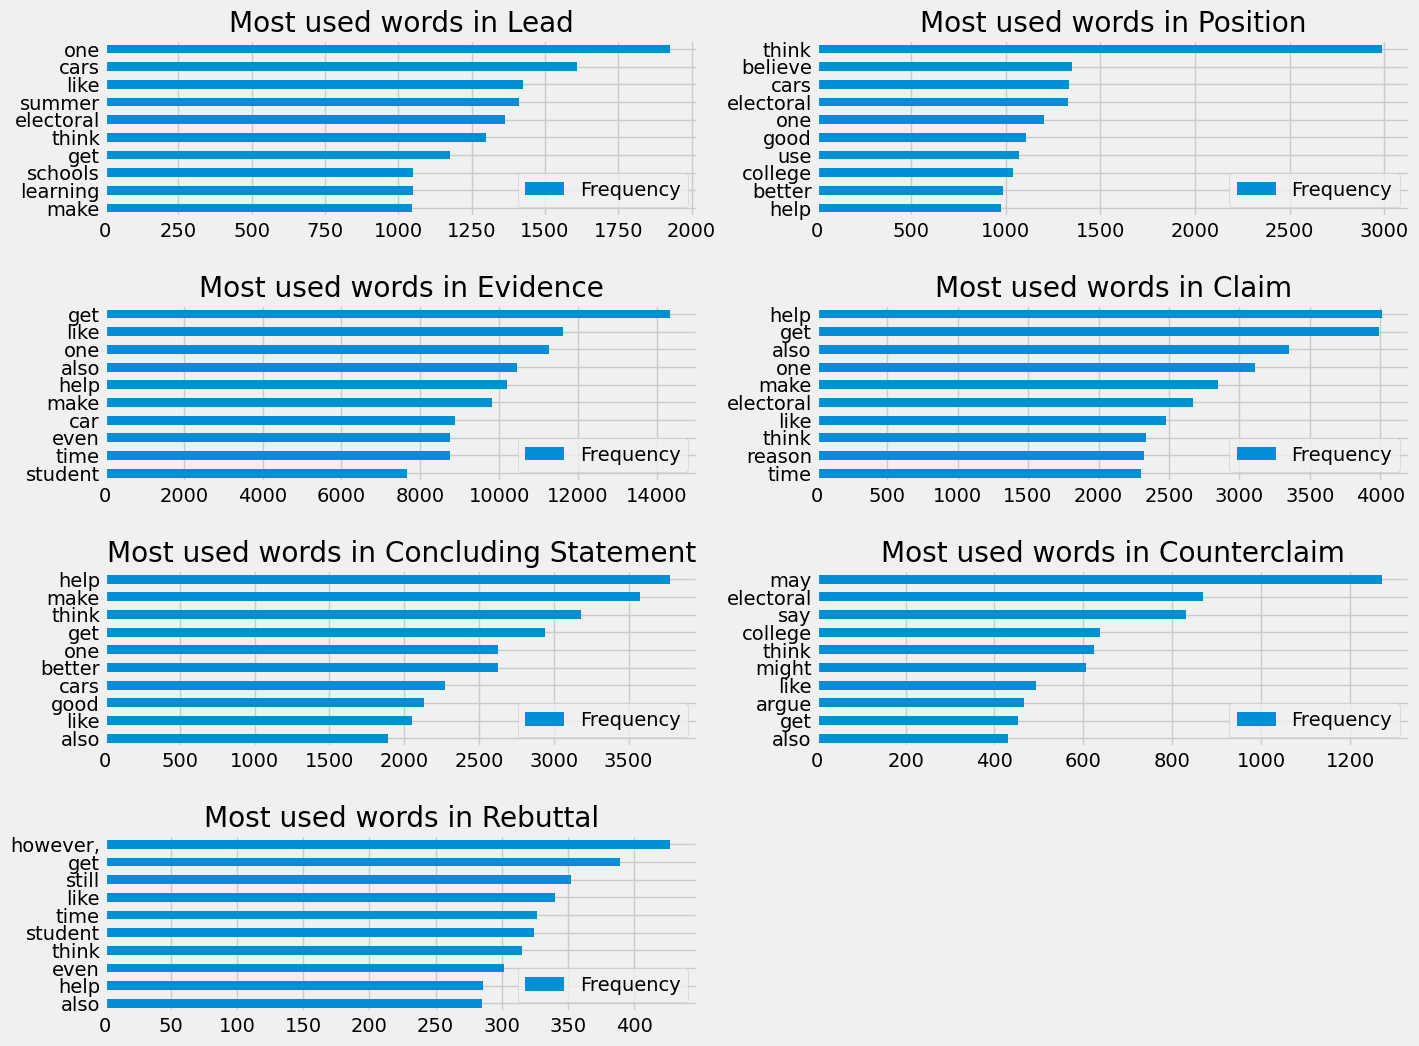

In [26]:
train['discourse_text'] = train['discourse_text'].str.lower()

#get stopwords from nltk library
stop_english = stopwords.words("english")
other_words_to_take_out = ['school', 'students', 'people', 'would', 'could', 'many']
stop_english.extend(other_words_to_take_out)

#put dataframe of Top-10 words in dict for all discourse types
counts_dict = {}
for dt in train['discourse_type'].unique():
    df = train.query('discourse_type == @dt')
    text = df.discourse_text.apply(lambda x: x.split()).tolist()
    text = [item for elem in text for item in elem]
    df1 = pd.Series(text).value_counts().to_frame().reset_index()
    df1.columns = ['Word', 'Frequency']
    df1 = df1[~df1.Word.isin(stop_english)].head(10)
    df1 = df1.set_index("Word").sort_values(by = "Frequency", ascending = True)
    counts_dict[dt] = df1

plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

keys = list(counts_dict.keys())

for n, key in enumerate(keys):
    ax = plt.subplot(4, 2, n + 1)
    ax.set_title(f"Most used words in {key}")
    counts_dict[keys[n]].plot(ax=ax, kind = 'barh')
    plt.ylabel("")

plt.show()

# Making n_grams for each discourse type

After the manual effort above, I was not fully pleased with the result and decided that I wanted to make a function to compose Top-10 n_grams per discount type by using CountVectorizer(). This function should also work for the single words (just run it with n_grams =1).

In [27]:

def get_n_grams(n_grams, top_n=10):
    df_words = pd.DataFrame()
    for dt in tqdm(train['discourse_type'].unique()):
        df = train.query('discourse_type == @dt')
        texts = df['discourse_text'].tolist()
        vec = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(n_grams, n_grams)).fit(texts)
        bag_of_words = vec.transform(texts)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        cvec_df = pd.DataFrame.from_records(words_freq, columns=['words', 'counts']).sort_values(by="counts", ascending=False)
        cvec_df.insert(0, "Discourse_type", dt)
        cvec_df = cvec_df.iloc[:top_n, :]
        df_words = pd.concat([df_words, cvec_df], ignore_index=True)
    return df_words

This function return one dataframe with 70 rows (the top 10 most used n-grams for each discourse type).

In [28]:
bigrams = get_n_grams(n_grams = 2, top_n=10)
bigrams.head()

  0%|          | 0/7 [00:00<?, ?it/s]

,Discourse_type,words,counts
0,Lead,electoral college,1179
1,Lead,driverless cars,808
2,Lead,cell phones,592
3,Lead,summer projects,513
4,Lead,distance learning,468


Below, I have also made a function that prints the results in this dataframe as subplots.

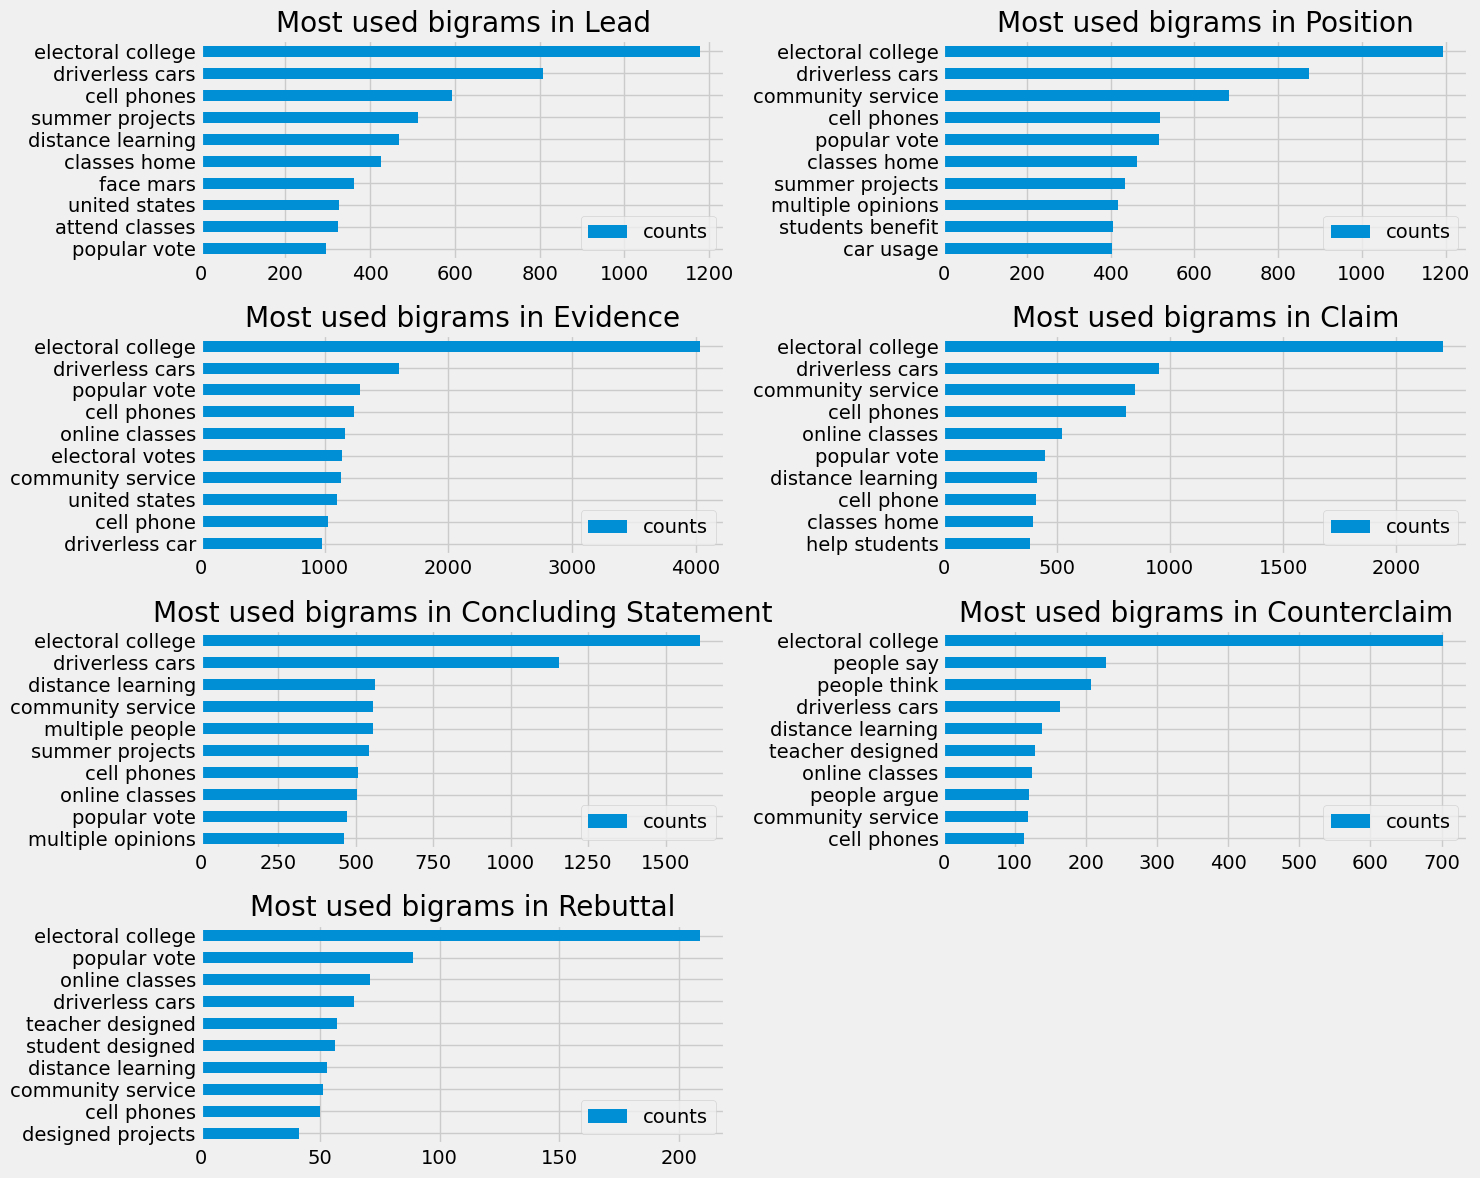

In [29]:
def plot_ngram(df, type = "bigrams"):
    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)

    for n, dt in enumerate(df.Discourse_type.unique()):
        ax = plt.subplot(4, 2, n + 1)
        ax.set_title(f"Most used {type} in {dt}")
        data = df.query('Discourse_type == @dt')[['words', 'counts']].set_index("words").sort_values(by = "counts", ascending = True)
        data.plot(ax=ax, kind = 'barh')
        plt.ylabel("")
    plt.tight_layout()
    plt.show()
    
plot_ngram(bigrams)

  0%|          | 0/7 [00:00<?, ?it/s]

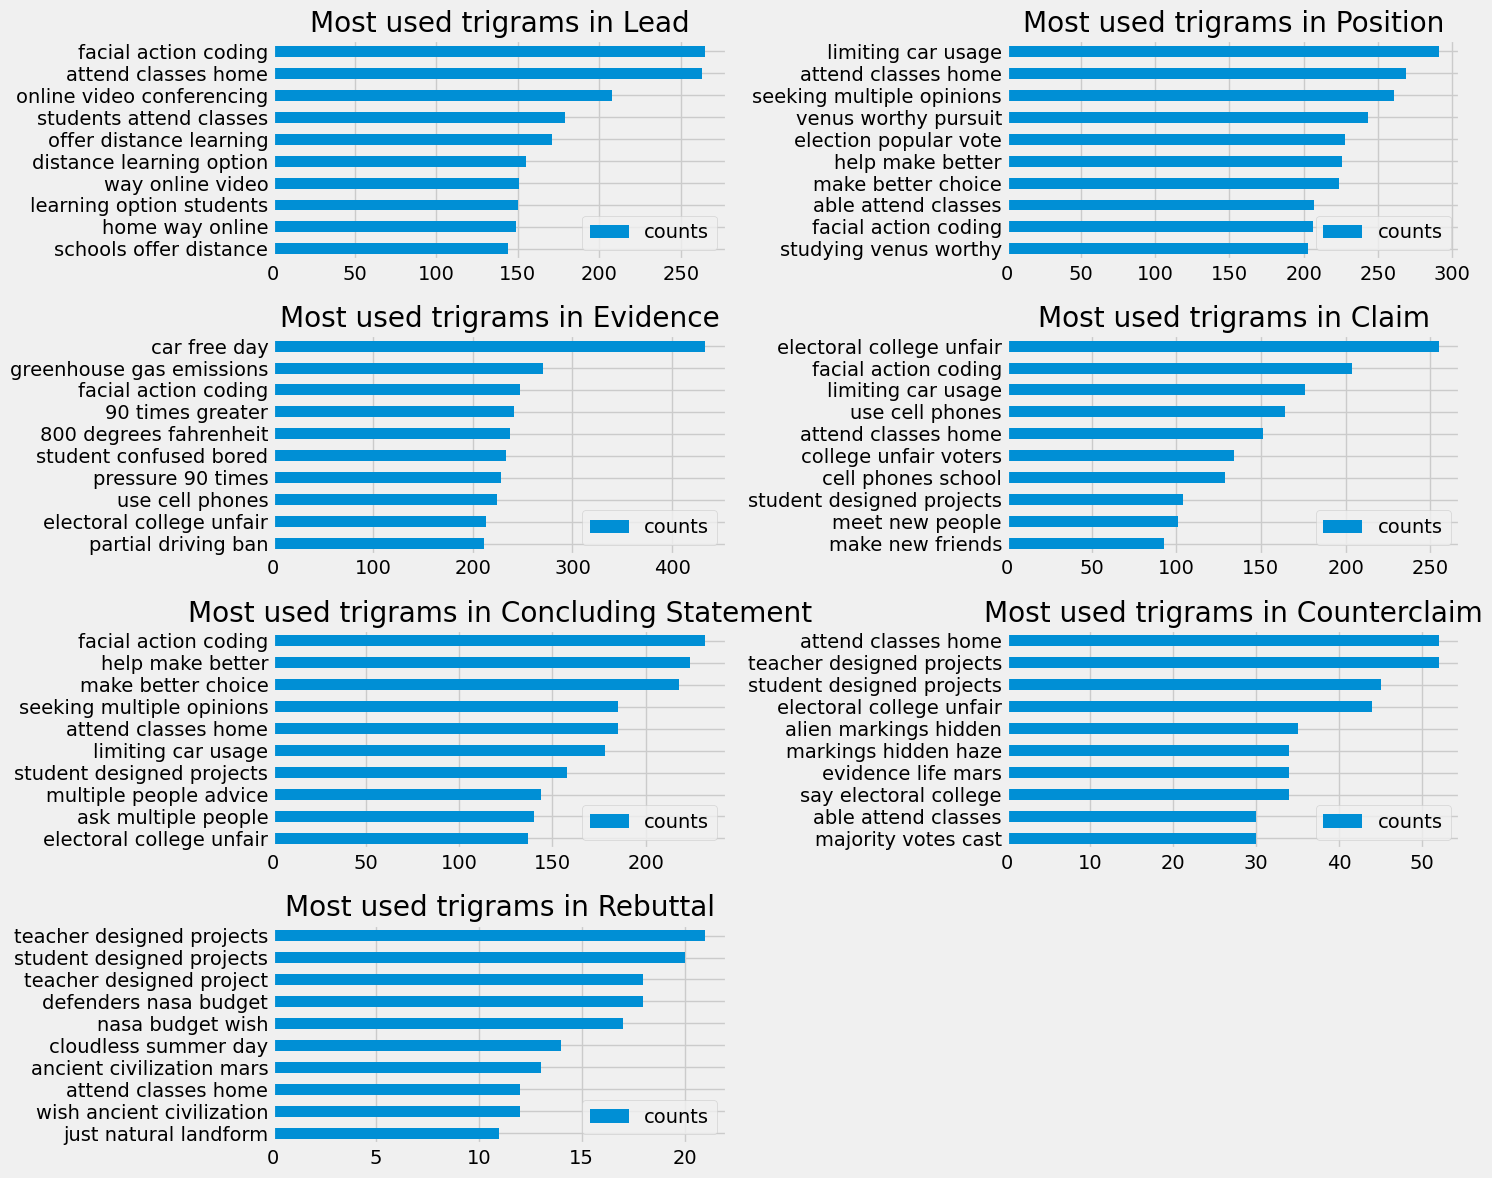

In [30]:
trigrams = get_n_grams(n_grams = 3, top_n=10)
plot_ngram(trigrams, type = "trigrams")

In [31]:
# https://www.kaggle.com/raghavendrakotala/fine-tunned-on-roberta-base-as-ner-problem-0-533
test_names, train_texts = [], []
for f in tqdm(list(os.listdir('../input/feedback-prize-2021/train'))):
    test_names.append(f.replace('.txt', ''))
    train_texts.append(open('../input/feedback-prize-2021/train/' + f, 'r').read())
train_text_df = pd.DataFrame({'id': test_names, 'text': train_texts})
train_text_df.head()

  0%|          | 0/15594 [00:00<?, ?it/s]

,id,text
0,62C57C524CD2,I think we should be able to play in a sport i...
1,80667AD3FFD8,Some schools require summer projects for stude...
2,21868C40B94F,Driverless cars have been argued and talked ab...
3,87A6EF3113C6,"The author of ""The Challenge of Exploring Venu..."
4,24687D08CFDA,"Wow, from the mar really look like humans face..."


Now we are ready to add a column with NER entities to this dataframe.

In [32]:
all_entities = []
#loop over dataframe with all full texts
for i in tqdm(range(len(train_text_df))):
    total = len(train_text_df.loc[i, 'text'].split())
    #now a list with length the total number of words in an essay is initialised with all values being "O"
    entities = ["O"]*total
    #now loop over dataframe with all discourses of this particular essay
    discourse_id = train_text_df.loc[i, 'id']
    train_df_id = train.query('id == @discourse_id').reset_index(drop=True)
    for j in range(len(train_df_id)):
        discourse = train_df_id.loc[j, 'discourse_type']
        #make a list with the position numbers in predictionstring converted into integer
        list_ix = [int(x) for x in train_df_id.loc[j, 'predictionstring'].split(' ')]
        #now the entities lists gets overwritten where there are discourse identified by the experts
        #the first word of each discourse gets prefix "Beginning"
        entities[list_ix[0]] = f"B-{discourse}"
        #the other ones get prefix I
        for k in list_ix[1:]: entities[k] = f"I-{discourse}"
    all_entities.append(entities)
    
    
train_text_df['entities'] = all_entities

  0%|          | 0/15594 [00:00<?, ?it/s]

In [33]:
train_text_df.head()

,id,text,entities
0,62C57C524CD2,I think we should be able to play in a sport i...,"[B-Position, I-Position, I-Position, I-Positio..."
1,80667AD3FFD8,Some schools require summer projects for stude...,"[B-Position, I-Position, I-Position, I-Positio..."
2,21868C40B94F,Driverless cars have been argued and talked ab...,"[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea..."
3,87A6EF3113C6,"The author of ""The Challenge of Exploring Venu...","[B-Position, I-Position, I-Position, I-Positio..."
4,24687D08CFDA,"Wow, from the mar really look like humans face...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea..."


**Thanks for your attention! If you like this notebook, an upvote is always appreciated.**